In [1]:
# ライブラリ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import pickle
from tqdm.notebook import tqdm
import japanize_matplotlib
import matplotlib.cm as cm

!pip install japanize-matplotlib

In [2]:
path_1 = "./folder_05/"
file_mesh = 'mesh_list_2021.pickle'
file_hsdn = "hsdn.csv"
file_category =  "category.csv"

In [3]:
#HSDN読込
hsdn = pd.read_csv(path_1+file_hsdn)
#閾値設定
hsdn = hsdn[hsdn["cosine_similarity"]>0.1]

In [4]:
#2021_mesh
with open(file_mesh, 'rb') as f:
    mesh_list = pickle.load(f)

#Zhouらの定義した疾患MeSH
all_disease = [descriptor for descriptor in mesh_list for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]

#重複削除
disease_mesh = []
[dm for dm in all_disease if dm not in disease_mesh and not disease_mesh.append(dm)]

print("all_mesh:", len(mesh_list), "disease_mesh:", len(disease_mesh))

all_mesh: 29917 disease_mesh: 4887


In [5]:
#treecode単位にMeSHデータをばらす
each_category = [[i[1], category] for i in disease_mesh for category in i[2]]
print(len(each_category))

12542


In [6]:
#臓器の日本語名(ja)で分類する
#「臓器名か臓器+diseases等…」を持つメッシュ語彙を探し、その英語表記形(en)とツリー番号(treecode)を取り出したもの
cate_ja = pd.read_csv(path_1+file_category)

In [7]:
cate_ja[:5]

,ja,en,treecode
0,胃,Stomach,A03.556.875.875
1,胃,Gastrointestinal Diseases,C06.405
2,肝臓,Liver,A03.620
3,肝臓,Liver Diseases,C06.552
4,筋肉,Muscles,A02.633


In [8]:
#treecode単位でばらしたMeSHデータのうち日本語分類cate_jaのtreecodeに属しているもの を取り出す
cate_ja_df = pd.DataFrame()
for term in each_category:
    for ja, treecode in zip(cate_ja["ja"], cate_ja["treecode"]):
        if term[1].startswith(treecode):
            tmp_df = pd.DataFrame([term[0], term[1], ja, treecode]).T
            cate_ja_df = pd.concat([cate_ja_df, tmp_df], axis=0)
cate_ja_df.columns=["disease_2", "mesh_treecode", "ja", "ja_mesh_treecode"]
cate_ja_df = cate_ja_df.reset_index(drop=True)
print(len(cate_ja_df))

3441


In [9]:
each_category[:3]

[['Abdominal Injuries', 'C26.017'],
 ['Abdominal Neoplasms', 'C04.588.033'],
 ['Abetalipoproteinemia', 'C16.320.565.398.500.440.500']]

In [10]:
cate_ja_df[:3]

,disease_2,mesh_treecode,ja,ja_mesh_treecode
0,Acantholysis,C17.800.865.070,皮膚,C17.800
1,Acanthosis Nigricans,C17.800.621.430.530.100,皮膚,C17.800
2,Drug Resistant Epilepsy,C10.228.140.490.125,脳,C10.228.140


In [11]:
#targetの疾患名のMeSH表記形リストを作成
target_list = ["Diabetes Mellitus, Type 2", "Diabetes Mellitus, Type 1", "Arthritis, Rheumatoid","Schizophrenia" ]
#指定された疾患
#Type 2 Diabetes, →Diabetes Mellitus, Type 2
#Type1 Diabetes, →Diabetes Mellitus, Type 1
#Rheumatoid arthritis, →Arthritis, Rheumatoid
#Schizophrenia →Schizophrenia

In [12]:
#グラフの設定
plt.style.use('ggplot')
plt.rcParams.update({'font.size':8})

size=(5,4) #凡例を配置するため横長に
col=cm.Pastel1(np.arange(cate_ja["ja"].nunique())/(cate_ja["ja"].nunique())) 
#colormap
#https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

In [13]:
#円グラフ作成関数の定義

def make_pie(target):
    
    #disease_1列がtargetのもの
    tmp_df = hsdn[(hsdn["disease_1"]==target)].reset_index(drop=True)
    #disease_2列がtargetのもの
    tmptmp_df = hsdn[(hsdn["disease_2"]==target)][["disease_2", "disease_1","cosine_similarity"]].reset_index(drop=True)
    #tmp_dfと合体させるため列名を変更
    tmptmp_df = tmptmp_df.rename(columns={"disease_2":"disease_1", "disease_1":"disease_2"})
    #合体
    df = pd.concat([tmp_df, tmptmp_df], axis=0)
    df = df.sort_values(by="cosine_similarity", ascending=False)
    df = df.reset_index(drop=True)
    #print(len(tmp_df), len(tmptmp_df), len(df),"重複件数:", len(df[df.duplicated()]))
    target_with_category= pd.merge(df, cate_ja_df, on="disease_2")
    target_with_category.to_csv(target+".csv", index=False)
    
    data = target_with_category.value_counts("ja")
    label=target_with_category.value_counts("ja").index

    plt.figure(figsize=size, dpi=100)
    plt.pie(data, colors=col,
            counterclock=False,
            startangle=90,
            autopct=lambda p:'{:.1f}%'.format(p) if p>=3 else '', #autopct='%1.1f%%',
           )
    plt.subplots_adjust(left=0,
                        right=0.7)
    plt.legend(label,
               fancybox=True,
               loc='center left',
               bbox_to_anchor=(0.9,0.5),
              )
    plt.axis('equal') 
    plt.savefig(target+'.png',bbox_inches='tight',pad_inches=0.05)
    plt.title(target)
    plt.show()   

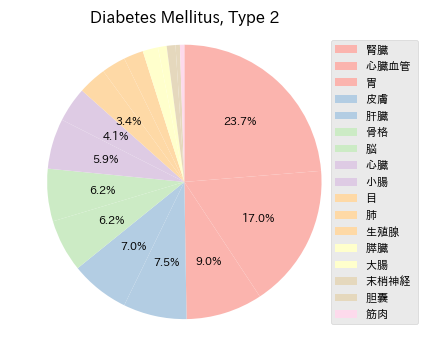

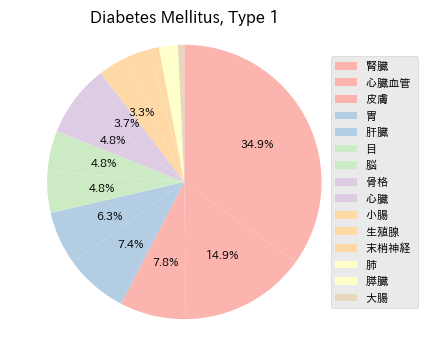

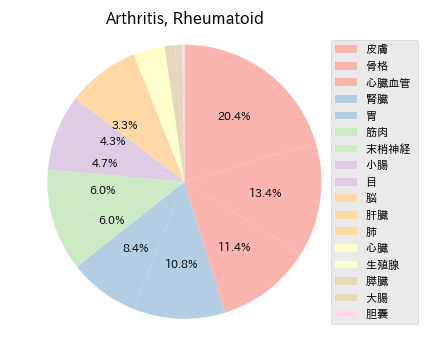

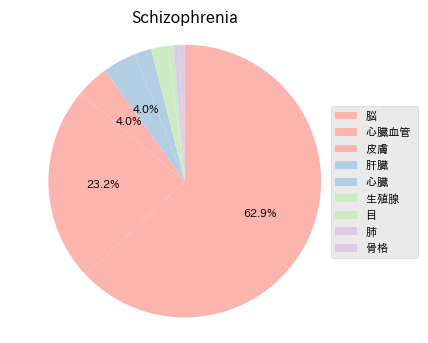

In [14]:
#実行
for target in target_list:
    make_pie(target)